# Aridity

Let's start by getting the basin geometry of USGS-01031500 station (Piscataquis River near Dover-Foxcroft, Maine)

In [1]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd

import pynhd as nhd

In [2]:
root = Path("input_data")
root.mkdir(exist_ok=True)
BASE_PLOT = {"facecolor": "k", "edgecolor": "b", "alpha": 0.2, "figsize": (18, 9)}
CRS = "esri:102008"
station_id = "01031500"

nldi = nhd.NLDI()
cfile = Path(root, f"basin_{station_id}.feather")
if cfile.exists():
    basin = gpd.read_feather(cfile)
else:
    basin = nldi.get_basins(station_id)
    basin.to_feather(cfile)

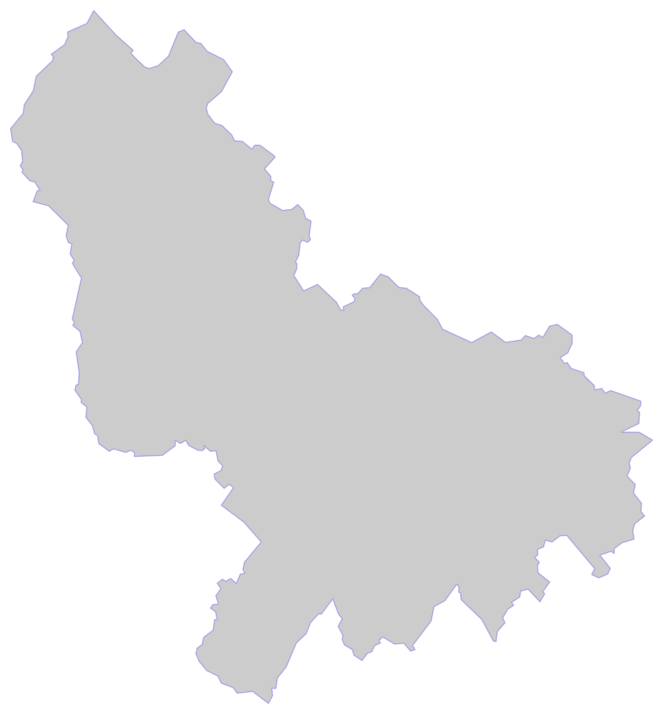

In [3]:
ax = basin.to_crs(CRS).plot(**BASE_PLOT)
ax.axis("off")
ax.margins(0)

### Precipitation and Potential Evapotranspiration

In [4]:
from tqdm.notebook import tqdm

import pydaymet as daymet

years = list(range(2006, 2016))
geometry = basin.iloc[0].geometry

for yr in tqdm(years, desc="Getting Climate"):
    cfile = Path(root, f"clm_{yr}.nc")
    if cfile.exists():
        continue
    daymet.get_bygeom(geometry, yr, variables="prcp", pet="hargreaves_samani").to_netcdf(cfile)

Getting Climate:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
import xarray as xr

clm = xr.open_mfdataset(Path(root).glob("clm_*.nc"), coords="minimal")
clm["elevation"] = clm["elevation"].isel(time=0, drop=True)
clm

<xarray.Dataset> Size: 259MB
Dimensions:    (time: 3650, y: 37, x: 40)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2006-01-01T12:00:00 ... 2015-12-31T...
  * y          (y) float32 148B 719.0 718.0 717.0 716.0 ... 685.0 684.0 683.0
  * x          (x) float32 160B 2.21e+03 2.211e+03 ... 2.248e+03 2.249e+03
Data variables:
    dayl       (time, y, x) float32 22MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    lat        (time, y, x) float64 43MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    lon        (time, y, x) float64 43MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    prcp       (time, y, x) float32 22MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    srad       (time, y, x) float32 22MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    tmax       (time, y, x) float32 22MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    tmin       (time, y, x) float32 22MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    vp         (time, y, x) float32 22MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
    elevation  (y, x) float64 12kB dask.array<chunksize=(37, 40), meta=np.ndarray>
    pet        (time, y, x) float64 43MB dask.array<chunksize=(365, 37, 40), meta=np.ndarray>
Attributes: (12/17)
    start_year:          2006
    source:              Daymet Software Version 4.0
    Version_software:    Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    ...                  ...
    geospatial_lon_max:  -69.13309404831536
    crs:                 +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-10...
    nodatavals:          0.0
    transform:           [ 1.00000e+00  0.00000e+00  2.20625e+03  0.00000e+00...
    res:                 [1. 1.]
    bounds:              [2209.24651856  682.07851575 2250.2123966   719.9719...

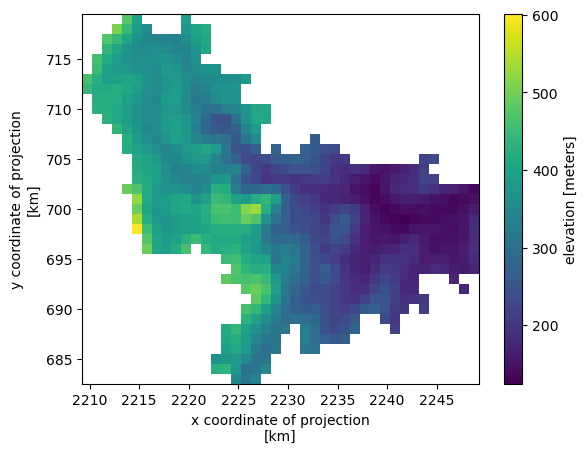

In [6]:
clm.elevation.plot()

In [7]:
import hvplot.xarray  # noqa

clm.hvplot.violin(y="pet", by="time.month")

:Violin   [time.month]   (pet)

### Aridity

In [8]:
variables = {"pet": "Mean Annual PET", "prcp": "Mean Annual P"}
data = {}
for v, n in variables.items():
    data[v] = clm[v].groupby("time.year").sum().mean(dim="year")
    data[v] = data[v].where(data[v] > 0)
    data[v] = data[v].rename(n)
    data[v] = data[v].assign_attrs(unit="mm/year")

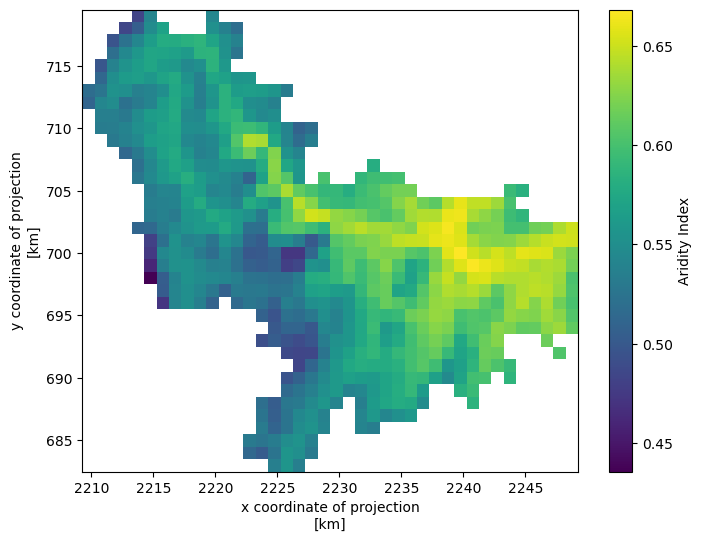

In [9]:
aridity = data["pet"] / data["prcp"]
aridity = aridity.rename("Aridity Index")

ax = aridity.plot(size=6)
ax.figure.savefig(Path("_static", "aridity.png"), dpi=300, bbox_inches="tight", facecolor="w")